# Random Forest MDD Severity Prediction

This notebook accompanies the repository "random-forest-mdd-severity-prediction". It loads clinical and demographic data, performs preprocessing, fits linear regression and Random Forest models to predict MADRS1, and evaluates performance using both a single train–test split and k-fold cross-validation.


In [4]:
!pip install matplotlib seaborn scikit-learn


  Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl (8.1 MB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ------------------ --------------------- 3.9/8.7 MB 19.6 MB/s eta 0:00:01
   ------------------------------------ --- 7.9/8.7 MB 19.5 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 18.1 MB/s  0:00:00
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp312-cp312-win_amd64.whl (2.3 MB)
Using cached kiwisolve


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\hcyeh\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os

# os.chdir(r"C:\Users\hcyeh\Downloads\random-forest-mdd-severity-prediction")


from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

plt.style.use("default")
pd.set_option("display.max_columns", None)


In [7]:
data_path = "data/mdd_scores_baseline.csv"
df = pd.read_csv(data_path)

df.head()


,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   number     55 non-null     object 
 1   days       55 non-null     int64  
 2   gender     55 non-null     int64  
 3   age        55 non-null     object 
 4   afftype    23 non-null     float64
 5   melanch    20 non-null     float64
 6   inpatient  23 non-null     float64
 7   edu        53 non-null     object 
 8   marriage   23 non-null     float64
 9   work       23 non-null     float64
 10  madrs1     23 non-null     float64
 11  madrs2     23 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 5.3+ KB


In [9]:
df.describe()


,days,gender,afftype,melanch,inpatient,marriage,work,madrs1,madrs2
count,55.000000,55.000000,23.000000,20.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,12.600000,1.454545,1.739130,1.950000,1.782609,1.521739,1.869565,22.739130,20.000000
std,2.491467,0.502519,0.540824,0.223607,0.421741,0.510754,0.344350,4.797892,4.729021
min,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,11.000000
25%,13.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,18.500000,16.000000
50%,13.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,24.000000,21.000000
75%,13.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,26.000000,24.500000
max,20.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,29.000000,28.000000


In [10]:
df.isnull().sum()


number        0
days          0
gender        0
age           0
afftype      32
melanch      35
inpatient    32
edu           2
marriage     32
work         32
madrs1       32
madrs2       32
dtype: int64

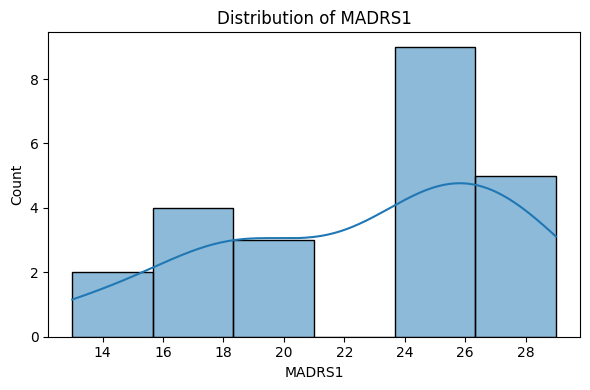

In [11]:
plt.figure(figsize=(6, 4))
sns.histplot(df["madrs1"], kde=True)
plt.xlabel("MADRS1")
plt.ylabel("Count")
plt.title("Distribution of MADRS1")
plt.tight_layout()
plt.show()


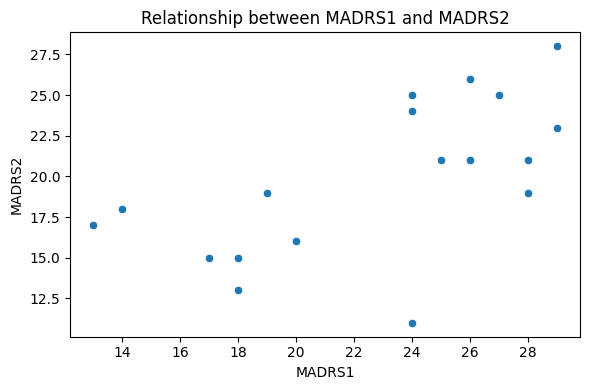

In [12]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df["madrs1"], y=df["madrs2"])
plt.xlabel("MADRS1")
plt.ylabel("MADRS2")
plt.title("Relationship between MADRS1 and MADRS2")
plt.tight_layout()
plt.show()


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((44, 11), (11, 11))

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

target_col = "madrs1"


df_clean = df.dropna(subset=[target_col]).copy()


X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

numeric_features = X.select_dtypes(include=["number"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numeric_features)
    ],
    remainder="drop"
)

linreg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

linreg_pipeline.fit(X_train, y_train)

y_pred_linreg = linreg_pipeline.predict(X_test)

mse_linreg = mean_squared_error(y_test, y_pred_linreg)
r2_linreg = r2_score(y_test, y_pred_linreg)

print(f"Linear Regression - Test MSE: {mse_linreg:.3f}")
print(f"Linear Regression - Test R^2: {r2_linreg:.3f}")


Linear Regression - Test MSE: 30.750
Linear Regression - Test R^2: -0.020


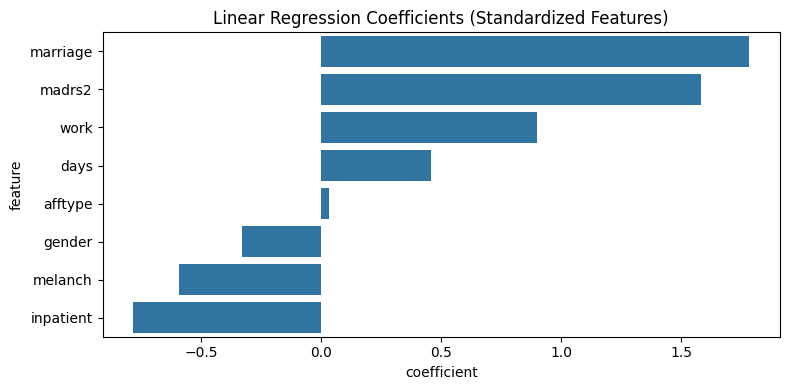

,feature,coefficient
5,marriage,1.784027
7,madrs2,1.582408
6,work,0.901235
0,days,0.458985
2,afftype,0.034242
1,gender,-0.330319
3,melanch,-0.590594
4,inpatient,-0.782801


In [20]:
linreg_model = linreg_pipeline.named_steps["model"]

coefs = linreg_model.coef_

coef_df = pd.DataFrame(
    {
        "feature": numeric_features,
        "coefficient": coefs
    }
).sort_values("coefficient", ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=coef_df, x="coefficient", y="feature")
plt.title("Linear Regression Coefficients (Standardized Features)")
plt.tight_layout()
plt.show()

coef_df


In [22]:
X_train_num = X_train.select_dtypes(include=["number"])
X_test_num = X_test.select_dtypes(include=["number"])

rf_model = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

rf_model.fit(X_train_num, y_train)

y_pred_rf = rf_model.predict(X_test_num)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Test MSE: {mse_rf:.3f}")
print(f"Random Forest - Test R^2: {r2_rf:.3f}")



Random Forest - Test MSE: 14.547
Random Forest - Test R^2: 0.518


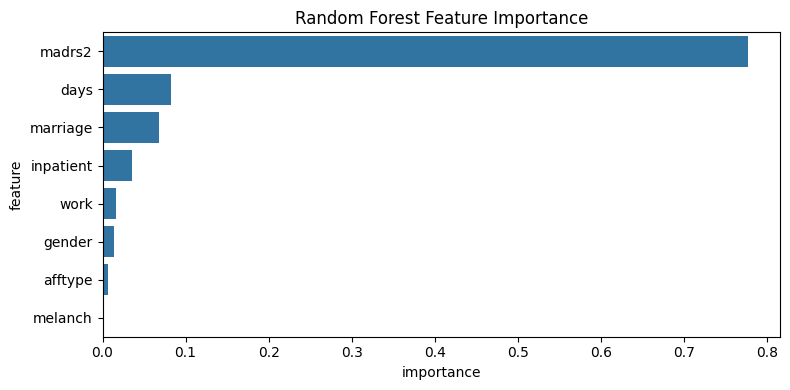

,feature,importance
7,madrs2,0.776598
0,days,0.082263
5,marriage,0.067604
4,inpatient,0.035218
6,work,0.015814
1,gender,0.014367
2,afftype,0.006425
3,melanch,0.001711


In [24]:
importances = rf_model.feature_importances_

rf_features = X_train_num.columns

fi_df = pd.DataFrame(
    {
        "feature": rf_features,
        "importance": importances
    }
).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=fi_df, x="importance", y="feature")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

fi_df



In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)


linreg_cv_scores = cross_val_score(
    linreg_pipeline,
    X,
    y,
    cv=kf,
    scoring="r2"
)


X_num = X.select_dtypes(include=["number"])

rf_cv_scores = cross_val_score(
    rf_model,
    X_num,
    y,
    cv=kf,
    scoring="r2"
)

print("Linear Regression CV R^2 scores:", linreg_cv_scores)
print("Linear Regression CV R^2 mean:", np.mean(linreg_cv_scores))

print("Random Forest CV R^2 scores:", rf_cv_scores)
print("Random Forest CV R^2 mean:", np.mean(rf_cv_scores))



Linear Regression CV R^2 scores: [-0.0195691  -1.35579426 -2.15885823  0.74886707 -0.16236817]
Linear Regression CV R^2 mean: -0.5895445404210633
Random Forest CV R^2 scores: [ 0.50637995 -1.56626186  0.74204103  0.72059841  0.62472591]
Random Forest CV R^2 mean: 0.2054966881494594


## Summary

The models in this notebook use a small set of clinical and demographic variables to predict MADRS1 severity scores. Linear regression provides an interpretable baseline, while the Random Forest model introduces nonlinear relationships and feature importance estimates.

Given the limited sample size, all performance metrics should be interpreted with caution. The current setup predicts MADRS1 from MADRS2 and other variables, which is useful for exploring associations but may not match every clinical use case. A possible next step is to invert the prediction target and model MADRS2 or change scores using baseline predictors.
